In [1]:
# Imports 

import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
import matplotlib.pyplot as plt

import statsmodels as sm
import statsmodels.api
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import adfuller
import pmdarima as pm
from pmdarima import model_selection
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import numpy as np
import sys
import pandas as pd 
import statsmodels as sm 
import warnings 
from scipy.stats import norm 
from statsmodels.tsa.stattools import acf 
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from math import sqrt
from multiprocessing import cpu_count
from joblib import Parallel
from joblib import delayed
from warnings import catch_warnings
from warnings import filterwarnings


In [2]:
# Reading the dataset

df = pd.read_csv("NKNBTC-1h-data.csv")

In [3]:
# Looking inside the dataset

df.head(10)

,timestamp,open,high,low,close,volume,close_time,quote_av,trades,tb_base_av,tb_quote_av,ignore
0,2019-10-11 14:00:00,0.000002,0.000004,0.000002,0.000003,61378855.0,1570805999999,206.007525,10706,26786806.0,90.468283,0
1,2019-10-11 15:00:00,0.000003,0.000004,0.000003,0.000004,93943900.0,1570809599999,344.185601,9412,50293108.0,185.414604,0
2,2019-10-11 16:00:00,0.000004,0.000004,0.000003,0.000003,22351455.0,1570813199999,79.138960,3509,7991178.0,28.326457,0
3,2019-10-11 17:00:00,0.000003,0.000004,0.000003,0.000003,10410267.0,1570816799999,36.492871,2239,4505189.0,15.807005,0
4,2019-10-11 18:00:00,0.000003,0.000004,0.000003,0.000003,5655694.0,1570820399999,19.574495,1022,2403788.0,8.352414,0
5,2019-10-11 19:00:00,0.000003,0.000004,0.000003,0.000003,5437409.0,1570823999999,18.582014,1092,1783351.0,6.123845,0
6,2019-10-11 20:00:00,0.000003,0.000003,0.000003,0.000003,6360390.0,1570827599999,20.960222,1456,2806312.0,9.219492,0
7,2019-10-11 21:00:00,0.000003,0.000003,0.000003,0.000003,4852142.0,1570831199999,16.007126,1100,2051767.0,6.758897,0
8,2019-10-11 22:00:00,0.000003,0.000003,0.000003,0.000003,2850167.0,1570834799999,9.214007,719,1033050.0,3.338245,0
9,2019-10-11 23:00:00,0.000003,0.000003,0.000003,0.000003,3556483.0,1570838399999,11.269391,714,1095437.0,3.482392,0


In [4]:
# Looking inside the dataset

df.tail(10)

,timestamp,open,high,low,close,volume,close_time,quote_av,trades,tb_base_av,tb_quote_av,ignore
4062,2020-03-29 07:00:00,0.000002,0.000002,0.000002,0.000002,217123.0,1585468799999,0.402419,36,60801.0,0.112642,0
4063,2020-03-29 08:00:00,0.000002,0.000002,0.000002,0.000002,426322.0,1585472399999,0.795311,41,301589.0,0.562586,0
4064,2020-03-29 09:00:00,0.000002,0.000002,0.000002,0.000002,192822.0,1585475999999,0.362013,66,104545.0,0.196647,0
4065,2020-03-29 10:00:00,0.000002,0.000002,0.000002,0.000002,511870.0,1585479599999,0.965825,83,251555.0,0.475738,0
4066,2020-03-29 11:00:00,0.000002,0.000002,0.000002,0.000002,170625.0,1585483199999,0.322499,30,19921.0,0.037670,0
4067,2020-03-29 12:00:00,0.000002,0.000002,0.000002,0.000002,251124.0,1585486799999,0.478597,53,66494.0,0.126888,0
4068,2020-03-29 13:00:00,0.000002,0.000002,0.000002,0.000002,1502942.0,1585490399999,2.898356,338,1099525.0,2.122566,0
4069,2020-03-29 14:00:00,0.000002,0.000002,0.000002,0.000002,1573326.0,1585493999999,3.034633,133,471389.0,0.914091,0
4070,2020-03-29 15:00:00,0.000002,0.000002,0.000002,0.000002,303267.0,1585497599999,0.581592,50,97145.0,0.187365,0
4071,2020-03-29 16:00:00,0.000002,0.000002,0.000002,0.000002,183747.0,1585501199999,0.350270,36,44462.0,0.084756,0


In [5]:
# Setting time series

df['timestamp'] = pd.to_datetime(df['timestamp'], format='%Y-%m-%d')
df = df.set_index("timestamp")


In [6]:
# Preparing time-series dataset

df.drop(["close_time","quote_av","trades","tb_base_av","tb_quote_av","ignore"],axis=1,inplace=True)

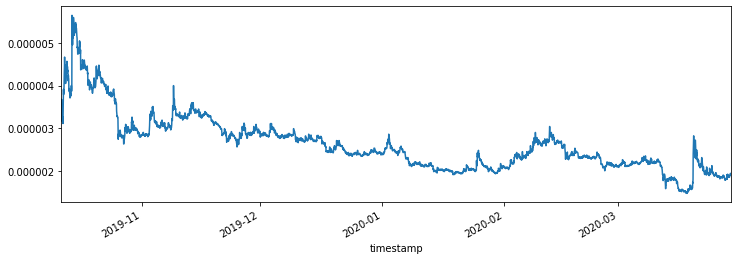

In [7]:
# Time-series plot

df["close"].plot(figsize=(12, 4))


In [8]:
# Making dataset lenght multiple of the window size

indx = df.shape[0] - int(df.shape[0]/110)*110

In [9]:
df=df[indx:]

In [10]:
df.shape

(4070, 5)

In [11]:
# Searching for nan or infinity values

np.all(np.isfinite(df))

True

In [12]:
# # In case that is not finite
# df.fillna(method='ffill', inplace=True)
# np.all(np.isfinite(df))

In [13]:
# Set the target column

target_column = "close"

In [14]:
def rolling_diagnostics(series, window=48):
    rolling = series.rolling(window)

    # create and customize the figures: top and bottom
    fig = plt.figure(figsize=(12, 6))
    ax_top = fig.add_subplot(211, title="Rolling mean", xlabel="Date", ylabel="value")
    ax_bottom = fig.add_subplot(212, title="Rolling std",
                                sharex=ax_top, xlabel="Date", ylabel="std")

    # draw plots:
    # series and rolling mean
    rolling.mean().plot(ax=ax_top)
    series.plot(ax=ax_top, color="black", lw=2, alpha=.25, zorder=-10)
    ax_top.grid(which="major", axis="both")

    # rolling std
    rolling.std().plot(ax=ax_bottom)
    ax_bottom.grid(which="major", axis="both")
    plt.savefig('Rolling_Diagnostics.png')

    fig.tight_layout()
    return fig

In [15]:
def yearly_seasonality_diagnostics(series, fraction=0.66, period="day"):

    # use nonparametric local linear regression for preliminary trend estimation
    trend = sm.api.nonparametric.lowess(series, np.r_[:len(series)],
                                        frac=fraction, it=5)

    # group by year and calculate the mean and std
    by = getattr(series.index, period, "day")
    season_groupby = (series - trend[:, 1]).groupby(by)
    seas_mean, seas_std = season_groupby.mean(), season_groupby.std()

    # create and customize the figures: top and bottom
    fig = plt.figure(figsize=(12, 6))
    ax_top = fig.add_subplot(211, title="Trend", xlabel="Date")
    ax_bottom = fig.add_subplot(212, title="Seasonality", xlabel=period)

    # draw plots:
    # series and trend
    pd.Series(trend[:, 1], index=series.index).plot(ax=ax_top)
    series.plot(ax=ax_top, color="black", lw=2, alpha=.25, zorder=-10)
    ax_top.grid(which="major", axis="both")

    # seasonality and 90% normal confidence interval
    ax_bottom.plot(1 + np.r_[:len(seas_mean)], seas_mean, lw=2)
    ax_bottom.fill_between(1 + np.r_[:len(seas_mean)],
                           seas_mean - 1.96 * seas_std,
                           seas_mean + 1.96 * seas_std,
                           zorder=-10, color="C1", alpha=0.15)
    ax_bottom.grid(which="major", axis="both")
    plt.savefig('Seasonality_Diagnostics.png')


    fig.tight_layout()
    return fig

In [16]:
def correlation_diagnostics(series, lags=48):
    # create and customize the figures: left and right
    fig = plt.figure(figsize=(12, 3))
    ax_left, ax_right = fig.subplots(
        nrows=1, ncols=2, sharey=True, sharex=True,
        subplot_kw={"xlabel": "Lag", "ylim": (-1.1, 1.1)})

    # draw plots using function from statsmodels
    plot_acf(series, ax_left, lags=lags, zero=False, alpha=0.05,
             title="Sample Autocorrelation", marker=None)

    plot_pacf(series, ax_right, lags=lags, zero=False, alpha=0.05,
              title="Sample Partial Autocorrelation", marker=None)
    plt.savefig('Correlation_Diagnostics.png')

    fig.tight_layout()
    return fig

In [17]:
def stat_test_diagnostics(series):
    return {
        "ADF": adfuller(series, regression="ct")[:2],
        "KPSS": kpss(series, regression="c")[:2],
    }

In [18]:
# Rolling characteristics, Correlation analysis, Testing hypotheses for processes stationarity

def diagnostics(series, window=250, fraction=0.25, lags=250):
    # rolling statistics
    rolling_diagnostics(series, window=window)
    plt.show()
    plt.close()

    # rough seasonality
    yearly_seasonality_diagnostics(series, fraction=fraction)
    plt.show()
    plt.close()

    # autocorrelations
    correlation_diagnostics(series, lags=lags)
    plt.show()
    plt.close()
    

    return stat_test_diagnostics(series)

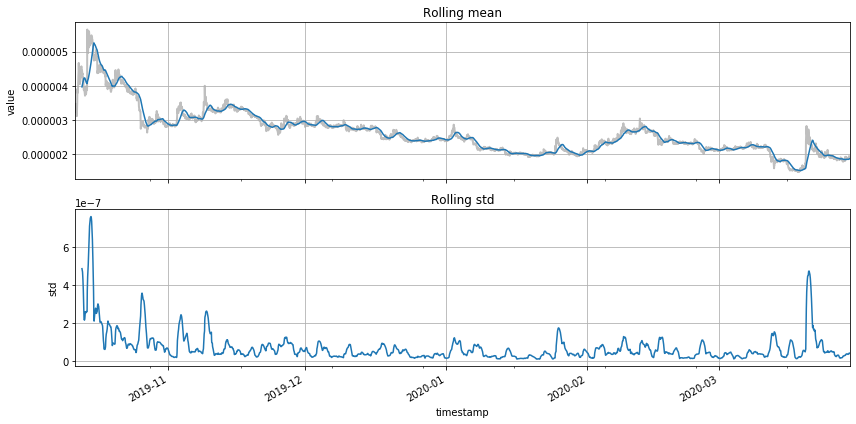

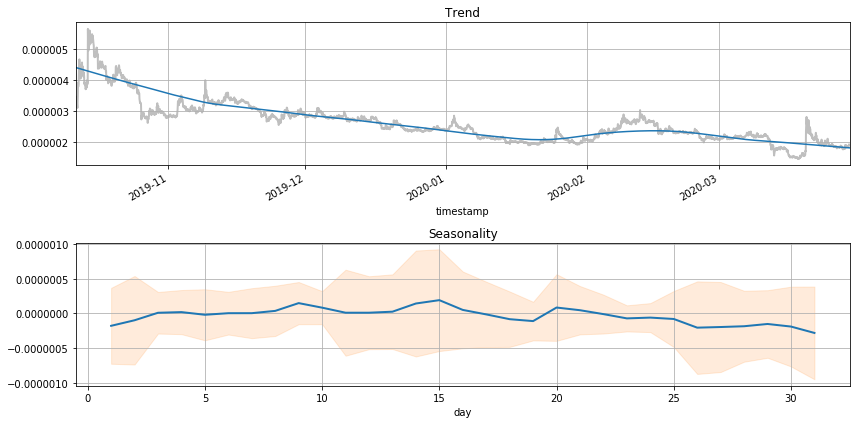

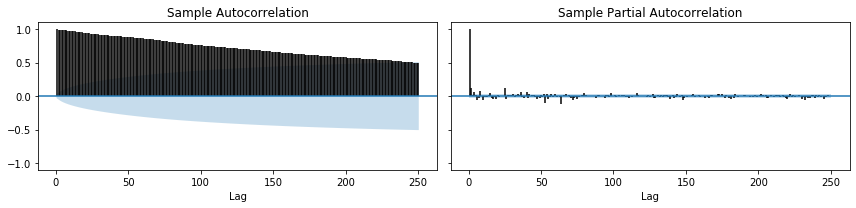

/home/yoel/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1685: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)


{'ADF': (-3.3182510628979576, 0.06330663398509605),
 'KPSS': (8.718278633080315, 0.01)}

In [19]:
# Time Series Visual Diagnostic

diagnostics(df[target_column], window=36)


# ARIMA Baseline Model

In [20]:
data = df[target_column]

In [21]:
def mean_absolute_percent_error(y_true, y_pred):
    pct_error = abs(y_true - y_pred) / abs(y_true)
    return pct_error.mean(axis=0) * 100

In [22]:
# 1 ARIMA Baseline Model

def ARIMA_Model(holdout,dataset):
        # Fit a simple auto_arima model
        modl = pm.auto_arima(dataset, start_p=0, start_q=0, start_P=0, start_Q=0,
                     max_p=5, max_q=5, max_P=5, max_Q=5, seasonal=True,
                     stepwise=True, suppress_warnings=True, D=10, max_D=10,
                     error_action='ignore')
        # Create predictions for the future, evaluate on test
        preds, conf_int = modl.predict(holdout, return_conf_int=True)
        return preds, conf_int

In [23]:
# Validating the model (Sliding Window)

loop_value = int(len(data)/100)
train_window_size = 100
test_window_size = 10
step_size = train_window_size + test_window_size
arima_prediction = []

for i in range(0,loop_value):
    arima_pred, arima_config = ARIMA_Model(test_window_size,data.iloc[i*train_window_size:(i+1)*train_window_size])
    arima_prediction.append(arima_pred)

In [24]:
# Compute Real Values every 100 hours

r_value=[]
for i in range(1,loop_value+1):
    v= data.iloc[i*100:i*train_window_size + test_window_size]
    r_value.append(v)

In [25]:
# Computing metrics (MAPE)

arima_mape_list=[]
for i in range(0,len(r_value)):
    mape=mean_absolute_percent_error(r_value[i],arima_prediction[i])
    arima_mape_list.append(mape)


In [26]:
# Mean Value of MAPE

arima_MAPE = sum(arima_mape_list)/len(arima_mape_list)

In [27]:
# Print MAPE

print("The Mean Absolute Percentage Error in ARIMA Model is equal to",round(arima_MAPE,2))

The Mean Absolute Percentage Error in ARIMA Model is equal to 17.11


In [28]:
# Train-test Split

train = data[10:]
test = data.tail(10)

In [29]:
# Forecasting t+10 timesteps

arima_forecast, arima_config = ARIMA_Model(10,train)


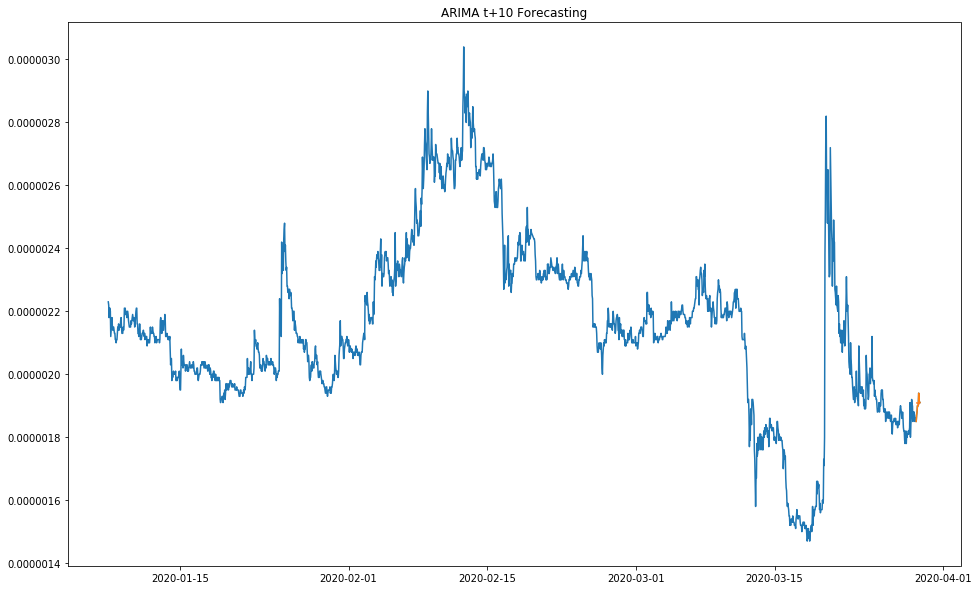

In [30]:
# Plot Forecasting Values

fig, ax = plt.subplots(figsize=(16, 10))
ax.plot(train[2100:].index, train.values[2100:]);
ax.plot(test.index, test.values, label='truth');
ax.plot(test.index, arima_forecast, linestyle='--', color='#ff7823');
ax.set_title("ARIMA t+10 Forecasting");
plt.savefig('ARIMA t+10 Forecasting.png')


# Theta Baseline Model

In [31]:
# 2 Theta Baseline Model

# Step 1: Check for seasonality
# Step 2: Decompose Seasonality if it is deemed seasonal
# Step 3: Applying Theta Method
# Step 4: Reseasonalize the resulting forecast


def sesThetaF(y, s_period , h = 10, level = np.array([90,95,99])):
	"""
	@param y : array-like time series data
	@param s_period : the no. of observations before seasonal pattern repeats
	@param h : number of period for forcasting
	@param level: confidence levels for prediction intervals
	"""
	if not s_period:
		print('ERROR: s_period variable only accepts positive integer.')
		sys.exit()


	fcast = {} # store result
	# Check seasonality
	x = y.copy()
	n = y.index.size
	m = s_period 

	if m > 1 and n > 2 * m:
		r = (acf(x, nlags = m))[1:]
		temp = np.delete(r, m-1)
		stat = np.sqrt((1+ 2 * np.sum(np.square(temp))) / n)
		seasonal = (abs(r[m-1])/stat) > norm.cdf(0.95)
	else:
		seasonal = False

	# Seasonal Decomposition
	origx = x.copy()
	if seasonal:
		decomp = seasonal_decompose(x, model = 'multiplicative')
		if decomp.seasonal < 1e-10 :
			warnings.warn('Seasonal indexes equal to zero. Using non-seasonal Theta method')
		else:
			x = decomp.observed/decomp.seasonal

	# Find theta lines
	model = SimpleExpSmoothing(x).fit()
	fcast['mean'] = model.forecast(h)
	num = np.array(range(0,n))
	temp = LinearRegression().fit(num.reshape(-1,1),x).coef_
	temp = temp/2
	alpha = np.maximum(1e-10, model.params['smoothing_level'])
	fcast['mean'] = fcast['mean'] + temp * (np.array(range(0,h)) + (1 - (1 - alpha)**n)/alpha)

	# Reseasonalize
	if seasonal:
		fcast['mean'] = fcast['mean'] *  np.repeat(decomp.seasonal[-m:], (1 + h//m))[:h]
		fcast['fitted'] = model.predict(x.index[0], x.index[n-1]) * decomp.seasonal
	else:
		fcast['fitted'] = model.predict(x.index[0], x.index[n-1])

	fcast['residuals'] = origx - fcast['fitted']

	return fcast
	# Prediction Intervals
    

In [32]:
data = pd.Series(df['close']).asfreq("H")

In [33]:
data.fillna(method='ffill', inplace=True)
np.all(np.isfinite(data))

True

In [34]:
# Validating the model (Sliding Window)

theta_pred_list=[]
for i in range(0,loop_value):
    theta_pred = sesThetaF(data[i*100:(i+1)*100],s_period=1,h = 10)
    theta_pred_list.append(theta_pred['mean'])
    

In [35]:
r_value=[]
for i in range(1,loop_value+1):
    v= data.iloc[i*100:i*train_window_size + test_window_size]
    r_value.append(v)

In [36]:
# Computing metrics (MAPE)

theta_mape_list=[]
for i in range(0,len(r_value)):
    mape=mean_absolute_percent_error(r_value[i],theta_pred_list[i])
    theta_mape_list.append(mape)

In [37]:
# Mean Value of MAPE

theta_MAPE = sum(theta_mape_list)/len(theta_mape_list)

In [38]:
# Print MAPE

print("The Mean Absolute Percentage Error in Theta Model is equal to",round(theta_MAPE,2))


The Mean Absolute Percentage Error in Theta Model is equal to 1.68


In [39]:
# Forecasting t+10 timesteps

theta_conf = sesThetaF(data,s_period=1,h = 10)


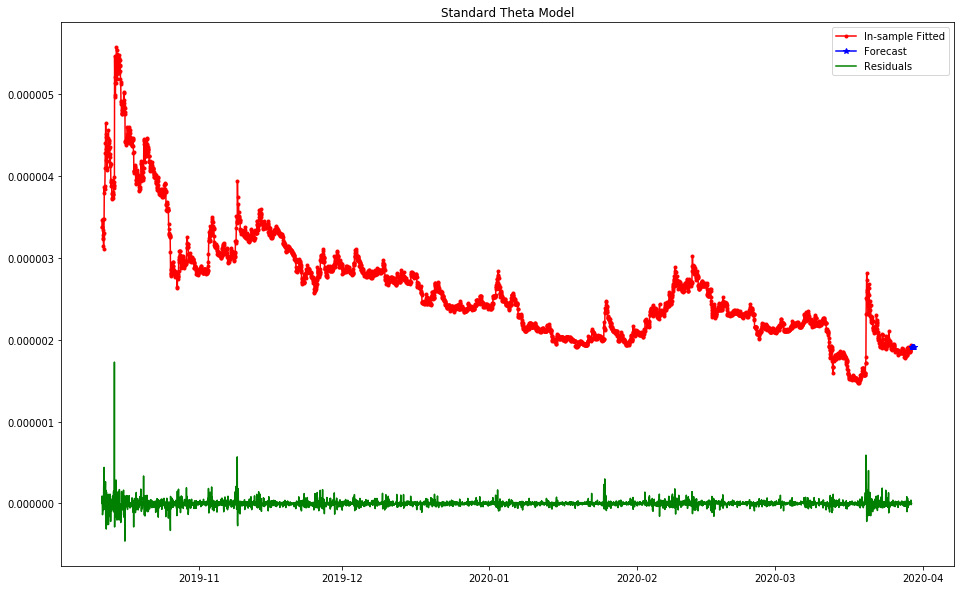

<Figure size 432x288 with 0 Axes>

In [40]:
# Plot Forecasting Values

mean = theta_conf['mean']

fitted =  theta_conf['fitted']

residuals = theta_conf['residuals']

plt.figure(figsize = (16,10))

plt.plot(fitted, marker = '.', color = 'red', label = 'In-sample Fitted')
plt.plot(mean, marker = '*', color = 'blue', label = 'Forecast')
plt.plot(residuals, marker = '', color = 'green', label = 'Residuals')
plt.title('Standard Theta Model')
plt.legend()
plt.show()
plt.savefig('Standard Theta Model t+10 Forecasting.png')

# HW Exponential Smoothing Baseline Model

In [41]:
# Dataset pre-processing

data = df[target_column]

In [42]:
data = pd.Series(df['close']).asfreq("H")

In [43]:
np.all(np.isfinite(data))

False

In [44]:
data.fillna(method='ffill', inplace=True)
np.all(np.isfinite(data))

True

In [45]:
# 3 HWES Baseline Model

exp_smooth_pred_list=[]

for i in range(0,loop_value):
    model = ExponentialSmoothing(data[i*100:(i+1)*100],freq="H")
    model_fit = model.fit()
    # make prediction
    yhat = model_fit.predict(100, 109)
    exp_smooth_pred_list.append(yhat)


In [46]:
exp_smooth_mape_list=[]
for i in range(0,len(r_value)):
    mape=mean_absolute_percent_error(r_value[i],exp_smooth_pred_list[i])
    exp_smooth_mape_list.append(mape)

In [47]:
exp_smooth_MAPE = sum(exp_smooth_mape_list)/len(exp_smooth_mape_list)

In [48]:
# Print MAPE

print("The Mean Absolute Percentage Error in Exponential Smoothing Method is equal to",round(exp_smooth_MAPE,2))


The Mean Absolute Percentage Error in Exponential Smoothing Method is equal to 1.61


In [49]:
# Train-test Split

train = data[10:]
test = data.tail(10)

In [50]:
# Forecasting t+10 timesteps
 
model = ExponentialSmoothing(train,freq="H")
model_fit = model.fit()
# make prediction
yhat = model_fit.predict(len(train), len(train)+9)
    


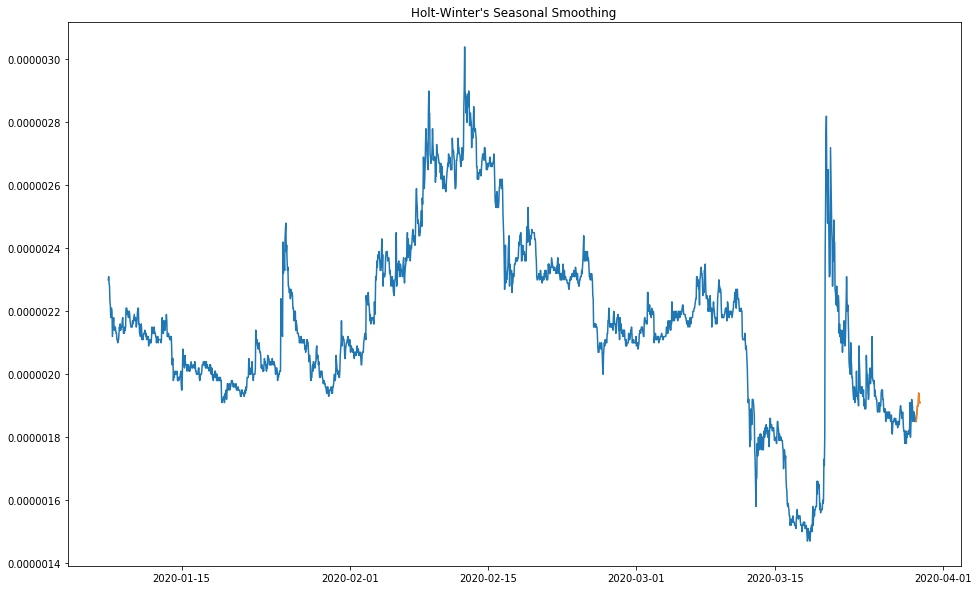

In [51]:
# Plot Forecasting Values

fig, ax = plt.subplots(figsize=(16, 10))
ax.plot(train[2100:].index, train.values[2100:]);
ax.plot(test.index, test.values, label='truth');
# ax.plot(test.index, yhat, linestyle='--', color='#ff7823');
ax.set_title("Holt-Winter's Seasonal Smoothing");
plt.savefig("Holt-Winter's Seasonal Smoothing t+10 Forecasting.png")
